In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import random
from tqdm import tqdm
import json
#data procedding
from sklearn.model_selection import train_test_split
#transformers
from transformers import DistilBertTokenizer
from transformers import AutoConfig
from transformers import AutoModelForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
#torch
from keras.utils import np_utils
import torch
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#set seed for reproducibility
seed=321
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
data = pd.read_json('~/environment/data/sample_1000000_2005_2018_cleaned.json')

In [4]:
data.head(1)

,index,text,stars,cleaned_text
1105058,2344352,Excellent food and customer service! My mom fo...,5,Excellent food and customer service ! My mom f...


In [5]:
data.stars.value_counts()

5    426404
4    266102
3    121561
1    102135
2     83798
Name: stars, dtype: int64

In [6]:
data['stars_reduce'] = data['stars']-1
dummy_y = np_utils.to_categorical(data.stars_reduce)
dummy_y.shape

(1000000, 5)

In [7]:
X_train, X_val,Y_train, Y_val = train_test_split(data.cleaned_text, dummy_y, test_size=0.2, 
                                                 stratify=dummy_y, random_state = seed)

In [8]:
MAX_LEN=512
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [9]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    labels = []
    
    for sent in data:
        encoded = tokenizer.encode(
            text=sent,
            add_special_tokens=True,
            truncation=True,
            max_length=MAX_LEN,
            padding=False
        )
        input_ids.append(encoded)
    return input_ids

In [10]:
train_ids = tokenize(X_train, MAX_LEN)
val_ids = tokenize(X_val, MAX_LEN)

In [11]:
#sort by length
train_samples = sorted(zip(train_ids, Y_train), key=lambda x: len(x[0]))
val_samples = sorted(zip(val_ids, Y_val), key=lambda x: len(x[0]))

In [12]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 512


In [13]:
def select_batches(samples, batch_size):
    batch_ordered_sentences = []
    batch_ordered_labels = []
    text_data = samples.copy()
    while len(text_data) > 0:
        to_take = min(batch_size, len(text_data))
        select = random.randint(0, len(text_data) - to_take)
        batch = text_data[select:(select + to_take)]
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])
        del text_data[select:select + to_take]
    # print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))
    return batch_ordered_sentences, batch_ordered_labels

In [14]:
def add_padding(batch_ordered_sentences, batch_ordered_labels):
    py_inputs = []
    py_attn_masks = []
    py_labels = []
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):
        batch_padded_inputs = []
        batch_attn_masks = []

        max_size = max([len(sen) for sen in batch_inputs])
        for sen in batch_inputs:
            num_pads = max_size - len(sen)
            padded_input = sen + [tokenizer.pad_token_id]*num_pads
            attn_mask = [1] * len(sen) + [0] * num_pads
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    return py_inputs,py_attn_masks,py_labels

In [15]:
def flat_accuracy(preds, labels):
    pred = np.argmax(preds, axis=1)+1
    label = np.argmax(labels, axis=1)+1
    # print('preds_flat ', pred)
    # print('labels_flat ', label)
    return np.sum(pred == label) / len(label)

In [16]:
config = AutoConfig.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',num_labels=5)
print('Config type:', str(type(config)), '\n')

model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',config=config)
print('\nModel type:', str(type(model)))

Config type: <class 'transformers.models.distilbert.configuration_distilbert.DistilBertConfig'> 



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas


Model type: <class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


In [17]:
print('\nLoading model to GPU...')
device = torch.device('cuda')
print('  GPU:', torch.cuda.get_device_name(0))
desc = model.to(device)
print('    DONE.')


Loading model to GPU...
  GPU: Tesla V100-PCIE-16GB
    DONE.


In [22]:
BatchSize=8
Epochs=2
TotalSteps = len(train_ids) * Epochs
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = TotalSteps)

In [24]:
def model_train(model, epochs, batch_size, train_data, val_data):
    # store evaluation metrics
    training_stats = []
    total_t0 = time.time()

    for epoch_i in range(0, epochs):
    # ========================================
    #               Training
    # ========================================
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        train_sentences, train_labels = select_batches(train_data, batch_size)
        train_input_ids, train_attention_masks, train_type_ids = add_padding(train_sentences, train_labels)

        
        print('Training on {:,} batches...'.format(len(train_input_ids)))
        t0 = time.time()
        total_train_accuracy = 0
        total_train_loss = 0
        model.train()
        for step in tqdm(range(0, len(train_input_ids))):
            b_input_ids = train_input_ids[step].to(device)
            b_input_mask = train_attention_masks[step].to(device)
            b_labels = train_type_ids[step].to(device)
            model.zero_grad()
            result = model(b_input_ids, 
                           # token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels,
                           return_dict = True)
            loss = result.loss
            total_train_loss += loss.item()
            logits = result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print('logits ', logits)
            # print('label_ids ', label_ids)
            total_train_accuracy += flat_accuracy(logits, label_ids)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_input_ids)
        avg_train_accuracy = total_train_accuracy / len(train_input_ids)
        training_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average training loss: {0:.4f}".format(avg_train_loss))
        print("  Average training accuracy: {0:.4f}".format(avg_train_accuracy))
        print("  Training epcoh {} took: {:}".format(epoch_i + 1, training_time))
    # ========================================
    #               Validation
    # ========================================
        val_sentences, val_labels = select_batches(val_data, batch_size)
        val_input_ids, val_attention_masks, val_type_ids = add_padding(val_sentences, val_labels)
        print('Validating on {:,} batches...'.format(len(val_input_ids)))
        t0 = time.time()
        total_val_accuracy = 0
        total_val_loss = 0
        model.eval()
        for step in tqdm(range(0, len(val_input_ids))):
            b_input_ids = val_input_ids[step].to(device)
            b_input_mask = val_attention_masks[step].to(device)
            b_labels = val_type_ids[step].to(device)
            with torch.no_grad():  
                val_result = model(b_input_ids, 
                                       #token_type_ids=None, 
                                       attention_mask=b_input_mask, 
                                       labels=b_labels)
            logits = val_result.logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            loss = val_result.loss
            total_val_loss += loss.item()
            total_val_accuracy += flat_accuracy(logits, label_ids)
        avg_val_accuracy = total_val_accuracy / len(val_input_ids)
        avg_val_loss = total_val_loss / len(val_input_ids)
        val_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
        print("")
        print("  Average validation loss: {0:.4f}".format(avg_val_loss))
        print("  Average validation accuracy: {0:.4f}".format(avg_val_accuracy))
        print("  Validation epcoh {} took: {:}".format(epoch_i + 1, val_time))
        torch.save(model.state_dict(), '/home/ubuntu/environment/model/distilbert_512_2005_2018_{}'.format(epoch_i + 1))
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Training Accuracy':avg_train_accuracy,
                'Training Time': training_time,
                'Validation Loss':avg_val_loss,
                'Validation Accuracy':avg_val_accuracy,
                'Validation Time': val_time,
            }
        )
    print("")
    print("Training complete!")
    total_time = str(datetime.timedelta(seconds = int(round(time.time() - total_t0))))
    print("Total training took: {:}".format(total_time))
    return training_stats

In [25]:
history = model_train(model, Epochs, BatchSize, train_samples, val_samples)


======== Epoch 1 / 2 ========
Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [1:31:01<00:00, 18.31it/s]



  Average training loss: 0.2488
  Average training accuracy: 0.7040
  Training epcoh 1 took: 1:31:02
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [04:44<00:00, 87.91it/s]



  Average validation loss: 0.2368
  Average validation accuracy: 0.7190
  Validation epcoh 1 took: 0:04:44

======== Epoch 2 / 2 ========
Training on 100,000 batches...


100%|█████████████████████████████████| 100000/100000 [1:31:41<00:00, 18.18it/s]



  Average training loss: 0.2283
  Average training accuracy: 0.7347
  Training epcoh 2 took: 1:31:41
Validating on 25,000 batches...


100%|█████████████████████████████████████| 25000/25000 [04:44<00:00, 87.83it/s]



  Average validation loss: 0.2370
  Average validation accuracy: 0.7211
  Validation epcoh 2 took: 0:04:45

Training complete!
Total training took: 3:13:15


In [ ]:
#torch.save(model.state_dict(), '/home/ubuntu/environment/model/distilbert_512_2005_2018')

In [26]:
with open("/home/ubuntu/environment/performance/distilbert_512_history.json", 'w') as f:
    json.dump(history, f, indent=2) 

In [27]:
history = pd.DataFrame.from_records(history)
history

,epoch,Training Loss,Training Accuracy,Training Time,Validation Loss,Validation Accuracy,Validation Time
0,1,0.248838,0.704001,1:31:02,0.236813,0.71899,0:04:44
1,2,0.228301,0.734670,1:31:41,0.237024,0.72112,0:04:45


Text(0.5, 1.0, 'Accuracy')

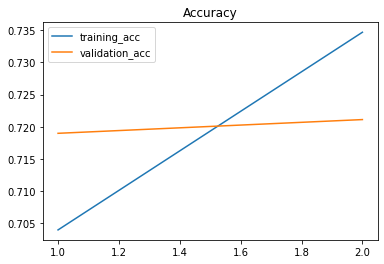

In [28]:
#plot accuracy
# plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history['Training Accuracy'])
plt.plot(range(1, Epochs+1), history['Validation Accuracy'])
plt.legend(['training_acc', 'validation_acc'])
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

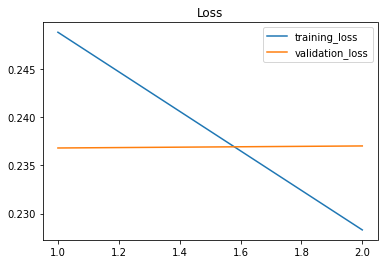

In [29]:
#plot loss
#plt.figure(figsize=(15, 7))
plt.plot(range(1, Epochs+1), history['Training Loss'])
plt.plot(range(1, Epochs+1), history['Validation Loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [31]:
model_loaded = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path='distilbert-base-uncased',config=config)
model_loaded.load_state_dict(torch.load('/home/ubuntu/environment/model/distilbert_512_2005_2018_2'))
device = torch.device('cuda')
desc = model_loaded.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [32]:
data_test= pd.read_json('~/environment/data/restaurant_review_2019_cleaned.json')

In [33]:
test_star_reduce = data_test['stars']-1
dummy_test_y = np_utils.to_categorical(test_star_reduce)

In [34]:
MAX_LEN=512
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
BatchSize=8

In [35]:
def fixed_padding(tokenizer, train_text, train_labels, batch_size, max_len):
    batches_input_ids = []
    batches_attention_masks = []
    batches_labels = []
    for i in tqdm(range(0, len(train_text), batch_size)):
        encoded_dict = tokenizer.batch_encode_plus(
            train_text[i:i+batch_size], # Batch of sentences to encode.
            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
            max_length = max_len,           # Pad & truncate all sentences.
            padding = 'max_length',     # Pad all to the `max_length` parameter.
            truncation = True,
            return_attention_mask = True,   # Construct attn. masks.
            return_tensors = 'pt',     # Return pytorch tensors.
        )
        batches_input_ids.append(encoded_dict['input_ids'])
        batches_attention_masks.append(encoded_dict['attention_mask'])
        batches_labels.append(torch.tensor(train_labels[i:i+batch_size]))
    return batches_input_ids,batches_attention_masks,batches_labels

In [44]:
train_input_ids, train_attention_masks, train_type_ids = fixed_padding(tokenizer, 
                                                                    X_train,
                                                                    Y_train,
                                                                    BatchSize, MAX_LEN)

100%|███████████████████████████████████| 100000/100000 [25:29<00:00, 65.37it/s]


In [45]:
val_input_ids, val_attention_masks, val_type_ids = fixed_padding(tokenizer, 
                                                                    X_val,
                                                                    Y_val,
                                                                    BatchSize, MAX_LEN)

100%|█████████████████████████████████████| 25000/25000 [06:20<00:00, 65.62it/s]


In [36]:
test_input_ids, test_attention_masks, test_type_ids = fixed_padding(tokenizer, 
                                                                    data_test.cleaned_text,
                                                                    dummy_test_y,
                                                                    BatchSize, MAX_LEN)

100%|█████████████████████████████████████| 65575/65575 [14:53<00:00, 73.41it/s]


In [37]:
def model_predict(model, batch_size, test_input_ids, test_attention_masks, test_type_ids):
    t0 = time.time()
    predictions , true_labels = [], []
    
    print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))
    model.eval()
    for step in tqdm(range(0, len(test_input_ids))):
        b_input_ids = test_input_ids[step].to(device)
        b_input_mask = test_attention_masks[step].to(device)
        b_labels = test_type_ids[step].to(device)
        with torch.no_grad():  
            outputs = model(b_input_ids, 
                                   #token_type_ids=None, 
                                   attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.append(logits)
        true_labels.append(label_ids)
    test_time = str(datetime.timedelta(seconds = int(round(time.time() - t0))))
    print("Total testing took: {:}".format(test_time))
    return predictions, true_labels

In [46]:
train_evals, train_stars = model_predict(model_loaded, BatchSize, train_input_ids, train_attention_masks, train_type_ids)

Predicting labels for 100,000 test sentences...


100%|█████████████████████████████████| 100000/100000 [1:11:29<00:00, 23.31it/s]

Total testing took: 1:11:29


In [47]:
train_eval = np.argmax(np.concatenate(train_evals, axis=0), axis = 1)+1
train_star = np.argmax(np.concatenate(train_stars, axis=0), axis = 1)+1

In [48]:
confusion_matrix(train_star, train_eval)

array([[ 69745,  10814,    858,     91,    200],
       [ 13617,  44000,   8448,    712,    261],
       [  2001,  15757,  54374,  22246,   2871],
       [   425,    825,   8172, 118983,  84477],
       [   328,    126,    510,  20388, 319771]])

In [49]:
print(classification_report(train_star, train_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.8099    0.8536    0.8312     81708
           2     0.6152    0.6563    0.6351     67038
           3     0.7514    0.5591    0.6412     97249
           4     0.7326    0.5589    0.6341    212882
           5     0.7846    0.9374    0.8542    341123

    accuracy                         0.7586    800000
   macro avg     0.7387    0.7131    0.7191    800000
weighted avg     0.7551    0.7586    0.7490    800000



In [50]:
val_evals, val_stars = model_predict(model_loaded, BatchSize, val_input_ids, val_attention_masks, val_type_ids)

Predicting labels for 25,000 test sentences...


100%|█████████████████████████████████████| 25000/25000 [17:52<00:00, 23.31it/s]

Total testing took: 0:17:52


In [51]:
val_eval = np.argmax(np.concatenate(val_evals, axis=0), axis = 1)+1
val_star = np.argmax(np.concatenate(val_stars, axis=0), axis = 1)+1

In [52]:
confusion_matrix(val_star, val_eval)

array([[16777,  3156,   312,    70,   112],
       [ 3959,  9803,  2577,   309,   112],
       [  619,  4519, 12074,  6154,   946],
       [  165,   314,  2692, 27224, 22825],
       [  180,    71,   224,  6460, 78346]])

In [53]:
print(classification_report(val_star, val_eval, digits = 4))

              precision    recall  f1-score   support

           1     0.7731    0.8213    0.7965     20427
           2     0.5488    0.5849    0.5663     16760
           3     0.6753    0.4966    0.5723     24312
           4     0.6769    0.5115    0.5827     53220
           5     0.7655    0.9187    0.8351     85281

    accuracy                         0.7211    200000
   macro avg     0.6879    0.6666    0.6706    200000
weighted avg     0.7136    0.7211    0.7096    200000



In [38]:
preds, stars = model_predict(model_loaded, BatchSize, test_input_ids, test_attention_masks, test_type_ids)

Predicting labels for 65,575 test sentences...


100%|█████████████████████████████████████| 65575/65575 [46:52<00:00, 23.32it/s]

Total testing took: 0:46:52


In [39]:
pred = np.argmax(np.concatenate(preds, axis=0), axis = 1)+1
star = np.argmax(np.concatenate(stars, axis=0), axis = 1)+1

In [40]:
confusion_matrix(data_test['stars'], pred)

array([[ 57904,   8878,   1020,    166,    436],
       [ 11577,  22579,   4983,    557,    257],
       [  2306,  12421,  25056,   9288,   1577],
       [   379,    808,   7031,  53889,  39209],
       [   452,    165,    628,  18969, 244058]])

In [41]:
print(classification_report(data_test['stars'], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7974    0.8465    0.8212     68404
           2     0.5034    0.5651    0.5325     39953
           3     0.6471    0.4947    0.5608     50648
           4     0.6503    0.5319    0.5852    101316
           5     0.8547    0.9235    0.8878    264272

    accuracy                         0.7691    524593
   macro avg     0.6906    0.6723    0.6775    524593
weighted avg     0.7610    0.7691    0.7620    524593



In [42]:
data_test['stars_distilbert_512'] = pred

In [43]:
data_test.to_json('~/environment/data/restaurant_review_2019_cleaned_distilbert_512_prediction.json')

In [ ]:
'''
padded_lengths = []

for batch in train_input_ids:
    for s in batch:
        padded_lengths.append(len(s))
smart_token_count = np.sum(padded_lengths)

fixed_token_count = len(X_train) * MAX_LEN
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))
'''